In [4]:
import numpy as np
import os

# Polars is an alternative to Pandas. We use it for its lazily evaluated dataframes (LazyFrame) to save memory when running
# this notebook.
import polars as pl

# Not all tools used are compatible with Polars
import pandas as pd

# An easy-to-use data generation tool
import sdv

from sdv.evaluation import multi_table, single_table
from sdv.metadata import SingleTableMetadata, MultiTableMetadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
from sdv.multi_table import HMASynthesizer

from sklearn import metrics
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [7]:
TARGET_COL = "in_ads"

In [8]:
# Without `infer_schema_length` set to a higher number, might not detect certain columns correctly
ad_data_orig = pl.scan_csv("data/train_data_ads.csv", infer_schema_length = 10000)
feed_data_orig = pl.scan_csv("data/train_data_feeds.csv", infer_schema_length = 10000)

Setting data types for some columns (list of integers, datetimes), renaming the user id in the feeds dataset to be `user_id`, and adding extra columns to the feeds dataset.

In [9]:
ad_data = ad_data_orig.with_columns(
    pl.col("ad_click_list_v001").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("ad_click_list_v002").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("ad_click_list_v003").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatInterestsST").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("pt_d").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
)
ad_user_ids = ad_data.select(pl.col("user_id")).unique()

In [10]:
feed_data = feed_data_orig.with_columns(
    pl.col("u_newsCatInterests").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatDislike").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_newsCatInterestsST").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("u_click_ca2_news").str.split("^").list.eval(pl.element().cast(pl.Int64)),
    pl.col("e_et").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
)
feed_data = feed_data.rename({ "u_userId": "user_id" })
feed_data = feed_data.with_columns(
    pl.col("i_cat").is_in(pl.col("u_newsCatInterests")).alias("Interested"),
    pl.col("i_cat").is_in(pl.col("u_newsCatDislike")).alias("Disliked"),
    pl.col("i_cat").is_in(pl.col("u_newsCatInterestsST")).alias("InterestedST"),
    pl.col("user_id").is_in(ad_user_ids.collect()).alias("in_ads"),
    # Potential
    pl.col("e_et").dt.hour().alias("hour"),
)

In [6]:
ad_data.fetch()

log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,list[i64],list[i64],list[i64],str,str,str,datetime[μs],list[i64],i64,i64
373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373251,0,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:26:00,"[39, 220, 16]",0,15
373255,0,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10.0,"[30157, 30648, … 31706]","[2066, 1776, 1036]","[114, 219, 312]","""24107""","""1218""","""173""",2022-06-03 03:28:00,"[39, 220, 16]",0,15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332115,0,100063,3,2,20,383,2,19,6,30,228,1505,7,15135,16636,8,1106,5,57,1,240,12,29,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 11:34:00,"[171, 65, … 112]",4,17
332172,0,100063,3,2,20,383,2,19,6,30,228,1284,7,33422,19818,8,1036,4,38,1,312,43,18,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 10:34:00,"[171, 65, … 112]",4,17
332174,0,100063,3,2,20,383,2,19,6,30,228,1505,7,33422,19818,8,1036,4,40,1,312,43,18,10.0,"[19427, 36257, … 20072]","[1036, 1220, … 1126]","[312, 280, … 367]","""24107""","""1218""","""173""",2022-06-03 10:25:00,"[171, 65, … 112]",4,17


In [7]:
feed_data.fetch()

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro,Interested,Disliked,InterestedST,in_ads,hour
i64,i64,i64,i64,i64,i64,list[i64],list[i64],list[i64],list[i64],str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],i64,i64,i64,bool,bool,bool,bool,i8
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""6e3e6bcb58d1fdd57b01a423f7a777…","""1eba881ea576fc05dfe457dd2111cd…",0,210,"""c7c6575e357e3e82c87fd04b04b28c…",4,1,13,19,1217,1,561,2,0,2022-06-08 15:21:00,-1,-1,0,false,false,false,false,15
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""f080276ae8aee56306253debbf643f…","""772b4a2593c3aa2590291f25d4bbc4…",0,219,"""40179dae61fecd7eaad86cdd128e70…",3,9,13,19,1217,9,561,1,0,2022-06-08 15:21:00,-1,-1,0,false,false,false,false,15
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""f6ee51f33fe8623b713a16287a873c…","""645e57afbbafce5159ab7fe956837c…",0,78,"""37d6e916f8c486d37683f03df3f578…",0,9,13,19,1217,18,561,1,0,2022-06-08 15:21:00,-1,-1,0,false,false,false,false,15
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""ee47079f7af99b70476161dbf5dcf0…","""9e5226ef81bf205dfe0ceefd6b7124…",1718,168,"""e36aff85ea6234ef8c68865db8abfc…",0,3,13,19,1217,7,561,1,1,2022-06-08 15:21:00,-1,-1,0,true,false,true,false,15
135880,16,17,10,17,0,"[195, 168, … 108]",[0],"[195, 44, … 21]","[195, 168, … 21]","""2363b609896dc2849cadf303a8d649…","""3a705744387ea91d68ce6b8172b528…",0,50,"""86d9e350f494a419533ebda912fd12…",9,9,13,19,1217,7,561,2,0,2022-06-08 15:22:00,-1,-1,0,false,false,false,false,15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
272174,11,17,14,15,0,[98],[0],[0],[98],"""cef0748681162c90fbbaeca9b6678c…","""da43cb15ed2d50d32fb518343f86b8…",1117,219,"""7c80405a35f2d0f72d11f5f2e46326…",9,9,13,19,1377,9,2589,1,0,2022-06-08 09:21:00,-1,-1,0,false,false,false,false,9
272174,11,17,14,15,0,[98],[0],[0],[98],"""80c6bd55b3c1988e3a59e90141d84f…","""1a3af1f28e25bedb03dc170b923e9c…",0,25,"""948545cca68fb18de0ef25e7d6bd2b…",2,9,13,19,1377,7,2589,1,1,2022-06-08 09:26:00,-1,-1,0,false,false,false,false,9
272174,11,17,14,15,0,[98],[0],[0],[98],"""5e25aa0caa288673a2e2bbccde9736…","""39c20be9cce448a7128ede705bc005…",0,25,"""08338e69ccacd288da8b68a6630c62…",0,4,13,19,1377,7,2589,1,1,2022-06-08 09:21:00,-1,-1,0,false,false,false,false,9


## Exploratory Data Analysis
We create some charts to analyze the data.

In [8]:
feed_data.select(pl.col("in_ads").value_counts()).unnest("in_ads").collect().plot.bar(x = "in_ads", y = "count")

:Bars   [in_ads]   (count)

In [9]:
# Age metrics
ad_data.group_by(pl.col("age")).len().sort("age").collect().plot.bar(x = "age", y = "len")

:Bars   [age]   (len)

In [10]:
ad_data.select(pl.col("city")).collect().plot.hist()

:Histogram   [city]   (city_count)

In [11]:
ad_data.group_by(pl.col("city")).agg(pl.len()).fetch().sort("len", descending = True)

city,len
i64,u32
179,243
383,76
429,66
162,27
310,23
…,…
191,7
113,7
319,6


In [12]:
ad_data.select(pl.col("device_name")).collect().plot.hist()

:Histogram   [device_name]   (device_name_count)

In [13]:
ad_data.select(pl.col("pt_d")).collect().plot.hist(bins = 100)

:Histogram   [pt_d]   (pt_d_count)

In [14]:
feed_data.select(pl.col("e_et")).collect().plot.hist(bins = 100)

:Histogram   [e_et]   (e_et_count)

In [15]:
ad_data.select(pl.col("pt_d").dt.hour()).collect().plot.hist(bins = 12)

:Histogram   [pt_d]   (pt_d_count)

In [16]:
feed_data.select(pl.col("e_et").dt.hour()).collect().plot.hist(bins = 24)

:Histogram   [e_et]   (e_et_count)

## Data Generation using SDV
SDV uses Pandas, which does not support list elements, so we must format the data for use.

In [11]:
# SDV uses Pandas, which does not support list elements, so we create separat
ad_pd_compat = ad_data_orig.with_columns([
    pl.col("pt_d").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
])
feed_pd_compat = feed_data_orig.rename({
    "u_userId": "user_id"
}).with_columns(
    pl.col("e_et").cast(pl.String).str.to_datetime("%Y%m%d%H%M"),
    pl.col("user_id").is_in(ad_user_ids.collect()).alias("in_ads"),
)

In [18]:
feed_meta = SingleTableMetadata()
# We know the data is already obfuscated, so we don't want to detect PII. Unfortunately, it doesn't look like
# SDV provides an option to do this, so we will need to update it manually.
# Using the whole dataset seems to reduce the number of columns detected as PII.
feed_meta.detect_from_dataframe(feed_pd_compat.collect().to_pandas())
feed_meta

{
    "columns": {
        "user_id": {
            "sdtype": "numerical"
        },
        "u_phonePrice": {
            "sdtype": "categorical"
        },
        "u_browserLifeCycle": {
            "sdtype": "categorical"
        },
        "u_browserMode": {
            "sdtype": "categorical"
        },
        "u_feedLifeCycle": {
            "sdtype": "categorical"
        },
        "u_refreshTimes": {
            "sdtype": "categorical"
        },
        "u_newsCatInterests": {
            "sdtype": "categorical"
        },
        "u_newsCatDislike": {
            "sdtype": "categorical"
        },
        "u_newsCatInterestsST": {
            "sdtype": "categorical"
        },
        "u_click_ca2_news": {
            "sdtype": "unknown",
            "pii": true
        },
        "i_docId": {
            "sdtype": "categorical"
        },
        "i_s_sourceId": {
            "sdtype": "categorical"
        },
        "i_regionEntity": {
            "sdtype": "numerical"


We can update columns if needed; SDV has detected PII, but these columns are already obfuscated, so we change the synthesizer metadata

In [19]:
feed_meta.update_column(
    column_name = "u_click_ca2_news",
    sdtype = "categorical",
)

In [20]:
feed_synth = GaussianCopulaSynthesizer(feed_meta)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


We take subset to improve training speed (though `GaussianCopulaSynthesizer` is decently fast, so this may not be necessary depending on your hardware). We can randomly sample to hopefully get more representative results. The following code might load the whole dataset into memory; it is possible to load only the first 10000 rows into memory if those rows can represent the dataset (using `Lazyframe.fetch`).

In [21]:
feed_synth.fit(feed_pd_compat.collect().sample(10000).to_pandas())

In [22]:
feed_synth_df = pl.from_pandas(feed_synth.sample(num_rows = 10000))
feed_synth_df.head(10)

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro,in_ads
i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],i64,i64,i64,bool
158700,14,17,13,17,5,"""78^98^98^57^57""","""0""","""171^21^78^51^98""","""171^153^98^216^195""","""3020db6ee8cd6331e52f8081e5efa6…","""8bfd032b50b89d2eaa8c957052a757…",1695,64,"""e3b1314a2ae95a105725ffa84f92f2…",1,9,13,18,120,8,1822,1,1,1970-01-20 03:38:56,-1,-1,100,false
181857,10,17,13,17,9,"""74^98""","""0""","""98^112^51^207^117""","""0^10^216^94^112""","""49a4586cc124c8252e863d362b21bb…","""1eba881ea576fc05dfe457dd2111cd…",2034,195,"""51e1a695bb06c480d5bef47de3a869…",4,0,11,20,602,13,2670,1,0,1970-01-20 03:31:51,-1,-1,100,false
199740,14,17,14,17,6,"""203^109^152^104^168""","""0""","""78^112^98^98^213""","""112^98^10^164^57""","""b4a40e02c95f3795b7bc1edcffa1d6…","""c4d3ed25402e08c1d3633c806bc098…",2495,214,"""1537a370b86025a9e52a6b32a76656…",0,3,13,20,1101,16,2327,1,0,1970-01-20 03:40:02,-1,-1,100,true
169532,16,16,11,17,0,"""140^213""","""0""","""0""","""216^100^171^98^169""","""e17514342b9d294cdfd97884fb76c9…","""0c7b8bcc1e8278af017da03e410f0d…",1530,23,"""c925f8d1326efea261e7e292ddc453…",1,3,11,19,159,14,2182,1,1,1970-01-20 03:37:08,-1,-1,99,false
160127,10,17,13,17,6,"""168^203^65^199^173""","""0""","""219^220^155^205^168""","""219^108^205^57^25""","""a377752d9f1a08453739b0c56b7344…","""0dea855e6e3ebbd683a009da861558…",1552,102,"""f1a9fbb5e072e0bb8ffa59246e05f6…",0,7,12,20,997,5,186,1,0,1970-01-20 03:32:38,1,-1,100,true
117059,14,17,13,17,8,"""98^112^143^143^143""","""0""","""46^218^168^112^219""","""74^98^112^8^38""","""c27f20f844ad75119917db632b9049…","""9e5226ef81bf205dfe0ceefd6b7124…",2838,3,"""7bc67f015cce5cf71f8a74d6d18ff1…",5,3,13,18,191,3,949,1,0,1970-01-20 03:31:09,-1,-1,97,true
181402,11,17,14,17,7,"""168^203^49^78^0""","""0""","""173^114^167^65^50""","""0^39^16^220^86""","""b49862d9ed1f9791366fa2f6dfbb00…","""ad4c3c013562e7b84ca4f0ddfd5d99…",214,139,"""d0b2e9032d2db5dadb0ecf415b3867…",0,6,10,13,1013,2,451,1,0,1970-01-20 03:32:19,-1,-1,100,true
273026,14,17,13,17,7,"""78^98^98^98^117""","""0""","""98^78^112^98^98""","""72^108^39^173^207""","""af1f0f5af528ca31dc461be93f2685…","""17e2096e1166ac681f04f5c8e25d2a…",2562,42,"""22a6d8320af93b24dac40a10b0aaec…",1,0,11,13,1337,10,875,1,1,1970-01-20 03:32:37,-1,-1,95,false
114904,14,16,13,16,8,"""100^216^44^112^57""","""0""","""195^171^25^100^57""","""98^57^219^112^109""","""d8d955ad1293855586cb50d92e718b…","""1a3af1f28e25bedb03dc170b923e9c…",2550,6,"""06513583e7b2f9fa4cd355dfbdbfb1…",2,0,11,20,742,5,1032,2,0,1970-01-20 03:30:18,1,-1,100,true


### Initial Synthetic Data Evaluation
SDV provides some evaluation tools for the synthetic data that we can use.

In [23]:
_ = single_table.run_diagnostic(
    real_data = feed_pd_compat.collect().sample(10000).to_pandas(),
    synthetic_data = feed_synth_df.to_pandas(),
    metadata = feed_meta
)

Generating report ...

(1/2) Evaluating Data Validity: |████████████████████| 29/29 [00:00<00:00, 490.32it/s]|
Data Validity Score: 85.02%

(2/2) Evaluating Data Structure: |█████████████████████| 1/1 [00:00<00:00, 311.01it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 92.51%



In [26]:
feed_synth_df.select(pl.col("in_ads").value_counts()).unnest("in_ads").plot.bar(x = "in_ads", y = "count")

:Bars   [in_ads]   (count)

In [27]:
ad_meta = SingleTableMetadata()
# Alternatively, we can fetch only the first N columns to create the metadata
# This will unfortunately mark the "log_id" column as a unique identifier column, so we'll
# have to change that
ad_meta.detect_from_dataframe(ad_pd_compat.fetch(1000).to_pandas())
ad_meta

{
    "columns": {
        "log_id": {
            "sdtype": "id"
        },
        "label": {
            "sdtype": "categorical"
        },
        "user_id": {
            "sdtype": "numerical"
        },
        "age": {
            "sdtype": "categorical"
        },
        "gender": {
            "sdtype": "categorical"
        },
        "residence": {
            "sdtype": "numerical"
        },
        "city": {
            "sdtype": "city",
            "pii": true
        },
        "city_rank": {
            "sdtype": "city",
            "pii": true
        },
        "series_dev": {
            "sdtype": "numerical"
        },
        "series_group": {
            "sdtype": "categorical"
        },
        "emui_dev": {
            "sdtype": "categorical"
        },
        "device_name": {
            "sdtype": "numerical"
        },
        "device_size": {
            "sdtype": "numerical"
        },
        "net_type": {
            "sdtype": "categorical"
        },
 

In [28]:
# We know these columns are already obfuscated (I think)
ad_meta.set_primary_key(None)
ad_meta.update_columns(
    column_names = ["city", "log_id", "city_rank"],
    sdtype = "numerical",
    computer_representation = "Int64",
)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/metadata/single_table.py:673: UserWarning: There is an existing primary key 'log_id'. This key will be removed.
  warnings.warn(


In [29]:
ad_synth = GaussianCopulaSynthesizer(ad_meta)

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [30]:
synth_ad_user_ids = feed_synth_df.filter(pl.col("in_ads"))["user_id"].unique()
synth_ad_user_ids

user_id
i64
100054
100071
100093
100120
100126
…
286956
286974
286976


In [31]:
ad_synth.fit(ad_pd_compat.collect().sample(10000).to_pandas())

We want to constrain the columns so they match the `in_ads` column in our synthetic feeds data.
This feels pretty primitive though.

In [32]:
ad_synth_target_size = 10000

ad_synth_df = pl.DataFrame(schema = ad_pd_compat.schema)

# This is really slow...
while ad_synth_df.height < ad_synth_target_size:
    ad_synth_df.extend(
        pl.from_pandas(ad_synth.sample(10 * (ad_synth_target_size - ad_synth_df.height))).filter(
            pl.col("user_id").is_in(synth_ad_user_ids)
        ).head(ad_synth_target_size - ad_synth_df.height)
    )

In [33]:
_ = single_table.run_diagnostic(
    real_data = ad_pd_compat.collect().sample(10000).to_pandas(),
    synthetic_data = ad_synth_df.to_pandas(),
    metadata = ad_meta
)

Generating report ...

(1/2) Evaluating Data Validity: |████████████████████| 35/35 [00:00<00:00, 538.21it/s]|
Data Validity Score: 88.31%

(2/2) Evaluating Data Structure: |█████████████████████| 1/1 [00:00<00:00, 476.19it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 94.15%



In [27]:
# Need to drop columns for CTGAN to have a hope of completing (GaussianCopula didn't work at all),
# though this may be dropping too many.
feed_b = feed_pd_compat.drop([
    "u_newsCatInterests",
    "u_newsCatDislike",
    "u_newsCatInterestsST",
    "i_docId",
    "i_s_sourceId",
    "i_entities",
])
ad_b = ad_pd_compat.drop([
    "u_newsCatInterestsST_right",
    "ad_click_list_v001",
    "ad_click_list_v002",
    "ad_click_list_v003",
])

In [28]:
# Funny way of trying to merge the dataframes
feed_c = feed_b.with_columns(pl.col("user_id").cum_count().over("user_id").alias("key"))
ad_c = ad_b.with_columns(pl.col("user_id").cum_count().over("user_id").alias("key"))
both_c = feed_c.join(ad_c, how = "left", on = ["user_id", "key"]).drop("key")

In [29]:
both_c_meta = SingleTableMetadata()
both_c_meta.detect_from_dataframe(both_c.fetch(100000).to_pandas())

In [30]:
both_c_meta

{
    "columns": {
        "user_id": {
            "sdtype": "numerical"
        },
        "u_phonePrice": {
            "sdtype": "categorical"
        },
        "u_browserLifeCycle": {
            "sdtype": "categorical"
        },
        "u_browserMode": {
            "sdtype": "categorical"
        },
        "u_feedLifeCycle": {
            "sdtype": "categorical"
        },
        "u_refreshTimes": {
            "sdtype": "categorical"
        },
        "u_click_ca2_news": {
            "sdtype": "unknown",
            "pii": true
        },
        "i_regionEntity": {
            "sdtype": "numerical"
        },
        "i_cat": {
            "sdtype": "numerical"
        },
        "i_dislikeTimes": {
            "sdtype": "categorical"
        },
        "i_upTimes": {
            "sdtype": "categorical"
        },
        "i_dtype": {
            "sdtype": "categorical"
        },
        "e_ch": {
            "sdtype": "numerical"
        },
        "e_m": {
          

In [31]:
both_c_meta.update_columns(
    column_names = ["city", "city_rank"],
    sdtype = "numerical",
)

In [ ]:
both_c_synth = CTGANSynthesizer(both_c_meta)
both_c_synth.fit(both_c.fetch(100000).to_pandas())

/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [83]:
both_c_synth_df = pl.from_pandas(both_c_synth.sample(100000))

In [91]:
both_c_synth_df.head(10)

user_id,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,i_docId,i_s_sourceId,i_regionEntity,i_cat,i_entities,i_dislikeTimes,i_upTimes,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro,in_ads,log_id,label_right,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST_right,u_refreshTimes_right,u_feedLifeCycle_right
i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],i64,i64,i64,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,datetime[μs],str,f64,f64
109663,10,13,14,11,0,"""216^0^171^100^59""","""0""","""219^98^199^218^25""","""sdv-pii-5l9f0""","""2ccfbff1668fda0e2d217f16ebb850…","""649d02b90c5b67640c52888c4b9120…",1,218,"""26fa2e6e0aa047e2d7b95561e9ff16…",3,0,13,14,413,4,2531,1,0,1970-01-20 03:37:43,-1,-1,0,false,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5.0,null,1.0,null,null,null,null,null,null,null,null,null,null,1970-01-20 03:30:41,null,null,null
266824,10,17,14,17,4,"""16^168^203^206^98""","""0""","""65^168^96^79^216""","""sdv-pii-l4zm6""","""0444fa6733879200fc5f47c0b2165e…","""1a3af1f28e25bedb03dc170b923e9c…",16,32,"""46dcda0c242fb1b908a5dc961e0a23…",0,2,13,15,184,24,544,1,1,1970-01-20 03:38:37,-1,-1,0,false,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1471.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
255414,14,17,14,17,6,"""168^98^98^98^17""","""0""","""78""","""sdv-pii-odpgt""","""0007d3220c4813d3527845e6c8b019…","""9c4c4e2467684537554e425a08ef61…",41,189,"""e1841685014be755f267d932a74231…",0,4,13,20,62,12,2178,1,1,1970-01-20 03:38:11,-1,-1,0,true,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,31.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
186341,14,17,10,17,4,"""86^86^71^169^104""","""0""","""199^168^17^25^80""","""sdv-pii-n9fr8""","""86ac869de6d3966e7924bd4040311e…","""1eba881ea576fc05dfe457dd2111cd…",0,203,"""07c2b7b0b4e22b989690adedc6814d…",2,4,11,19,1022,4,856,1,1,1970-01-20 03:38:28,-1,-1,0,true,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
102408,11,17,14,17,5,"""100^77^112^0^168""","""0""","""218^86^39^109^140""","""sdv-pii-t6332""","""c1bef0863ea8ca07e0930feabf24b5…","""2bc2357228735028a48afeb8fc890e…",0,88,"""5e38f55a1615ed09751e416b1a4ea6…",6,0,13,13,1123,7,2653,1,1,1970-01-20 03:38:48,1,-1,0,false,null,null,null,null,null,317.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
279262,11,17,14,17,9,"""216^59^100^199^0""","""0""","""168^100^41^98^171""","""sdv-pii-83dde""","""f9f181cdacc63d537a623df49ca648…","""fc832e8e0595603e2ad83130fa1a40…",0,18,"""5844ec13d8a7b9e973677616eaccbc…",0,0,13,18,1045,11,2666,1,1,1970-01-20 03:38:44,-1,-1,0,true,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,33.0,null,null,null,null,null,null,null,null,null,null,null,1970-01-20 03:30:42,null,null,null
148202,16,17,14,17,5,"""16^140^220^50^157""","""0""","""219^51^108^22^17""","""sdv-pii-51ctv""","""ead9bbcea965274d9cc21bd2a89e43…","""ec3a22480c651d6c5d5bdfaa5a85ad…",71,107,"""e87c59da3e1c9ae279620dbfd5a547…",3,7,13,20,1018,13,1584,8,0,1970-01-20 03:38:27,-1,-1,0,true,null,null,null,null,null,null,null,null,null,null,null,null,nul

In [84]:
feed_synth_df_2 = both_c_synth_df.select(feed_pd_compat.columns)
ad_synth_df_2 = both_c_synth_df.select(ad_pd_compat.columns).drop_nulls()

# Predicton Models

## Logistic Regression

In [34]:
model = LogisticRegression()

In [35]:
feed_data_num = feed_data.select(pl.exclude(pl.List(pl.Int64), pl.String, pl.Datetime))

In [36]:
# This may not work if the "Bokeh" library is missing
feed_data_num.fetch(10000).corr().with_columns(index = pl.Series(feed_data_num.columns)).melt(id_vars = "index").plot.heatmap(x = "index", y = "variable", C = "value")

:HeatMap   [index,variable]   (value)

In [37]:
rel_feed_cols = feed_data.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    "in_ads",
    # "InterestedST",
    # "hour",
])

data_cols = rel_feed_cols.collect()

In [38]:
train_df, test_df = train_test_split(data_cols)

In [39]:
train_X = train_df.select(pl.exclude(TARGET_COL))
train_y = train_df[TARGET_COL]
test_X = test_df.select(pl.exclude(TARGET_COL))
test_y = test_df[TARGET_COL]

In [40]:
fit_model = model.fit(
    train_X,
    train_y,
)

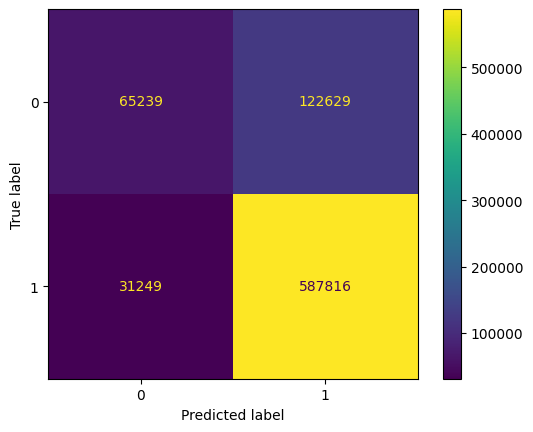

In [41]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_y, model.predict(test_X))
).plot()

In [42]:
print(metrics.classification_report(test_y, model.predict(test_X)))

              precision    recall  f1-score   support

       False       0.68      0.35      0.46    187868
        True       0.83      0.95      0.88    619065

    accuracy                           0.81    806933
   macro avg       0.75      0.65      0.67    806933
weighted avg       0.79      0.81      0.79    806933



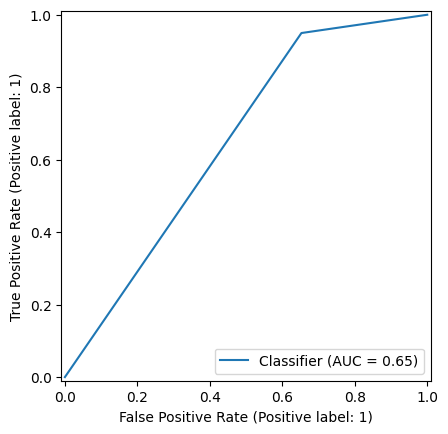

In [43]:
_ = metrics.RocCurveDisplay.from_predictions(test_y, model.predict(test_X))

## Naive Bayes Model

In [44]:
model_nb = GaussianNB()

In [45]:
rel_cols_nb = feed_data.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    TARGET_COL,
    #"InterestedST",
    #"hour",
])

In [46]:
train_df_nb, test_df_nb = train_test_split(rel_cols_nb.collect())

In [47]:
train_nb_X = train_df_nb.select(pl.exclude(TARGET_COL))
train_nb_y = train_df_nb[TARGET_COL]
test_nb_X = test_df_nb.select(pl.exclude(TARGET_COL))
test_nb_y = test_df_nb[TARGET_COL]

In [48]:
fit_model_nb = model_nb.fit(train_nb_X, train_nb_y)

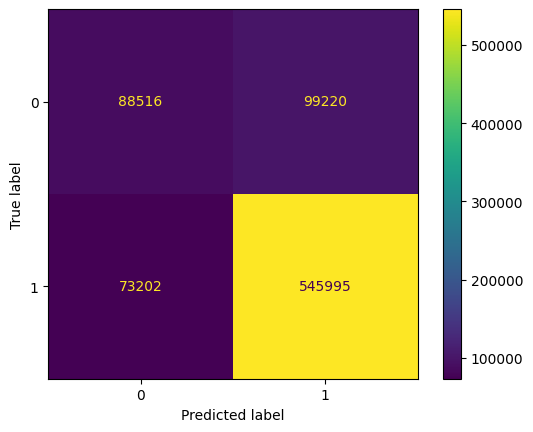

In [49]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_nb_y, fit_model_nb.predict(test_nb_X))
).plot()

In [50]:
print(metrics.classification_report(test_nb_y, model_nb.predict(test_nb_X)))

              precision    recall  f1-score   support

       False       0.55      0.47      0.51    187736
        True       0.85      0.88      0.86    619197

    accuracy                           0.79    806933
   macro avg       0.70      0.68      0.69    806933
weighted avg       0.78      0.79      0.78    806933



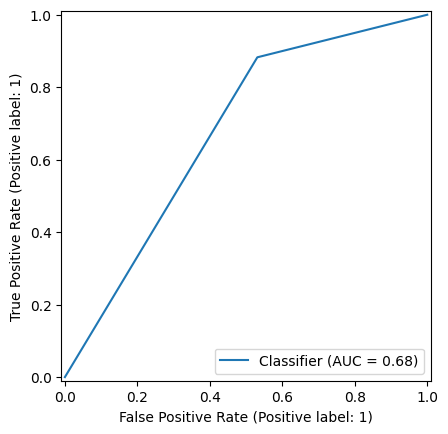

In [51]:
metrics.RocCurveDisplay.from_predictions(test_y, model_nb.predict(test_X))

## Gradient Boost

In [52]:
model_gb = HistGradientBoostingClassifier()

In [53]:
rel_cols_gb = feed_data.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
    TARGET_COL,
    #"InterestedST",
    # "hour",
])

In [54]:
train_df_gb, test_df_gb = train_test_split(rel_cols_gb.collect())

train_gb_X = train_df_gb.select(pl.exclude(TARGET_COL))
train_gb_y = train_df_gb[TARGET_COL]
test_gb_X = test_df_gb.select(pl.exclude(TARGET_COL))
test_gb_y = test_df_gb[TARGET_COL]

In [55]:
fit_model_gb = model_gb.fit(train_gb_X, train_gb_y)

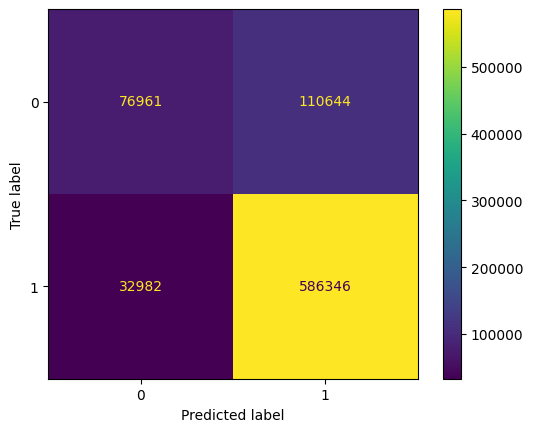

In [56]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_gb_y, fit_model_gb.predict(test_gb_X))
).plot()

In [57]:
print(metrics.classification_report(test_gb_y, model_gb.predict(test_gb_X)))

              precision    recall  f1-score   support

       False       0.70      0.41      0.52    187605
        True       0.84      0.95      0.89    619328

    accuracy                           0.82    806933
   macro avg       0.77      0.68      0.70    806933
weighted avg       0.81      0.82      0.80    806933



## Voting Classifier

In [58]:
model_voting = VotingClassifier([
    ("log_reg", LogisticRegression()),
    ("naive_bayes", GaussianNB()),
    ("random_forest", RandomForestClassifier()),
    ("grad_boost", HistGradientBoostingClassifier()),
])

In [59]:
model_voting.fit(train_X, train_y)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('naive_bayes', GaussianNB()),
                             ('random_forest', RandomForestClassifier()),
                             ('grad_boost', HistGradientBoostingClassifier())])

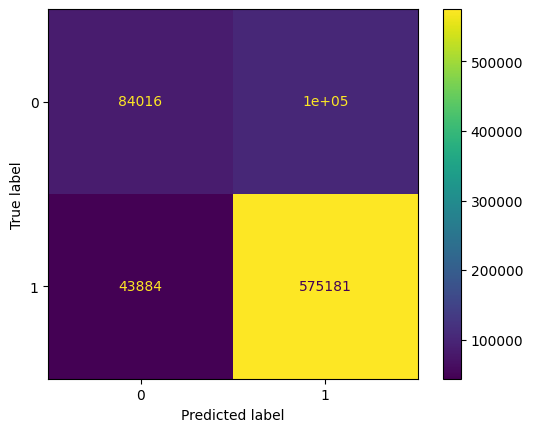

In [60]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(test_y, model_voting.predict(test_X))
).plot()

In [61]:
print(metrics.classification_report(test_y, model_voting.predict(test_X)))

              precision    recall  f1-score   support

       False       0.66      0.45      0.53    187868
        True       0.85      0.93      0.89    619065

    accuracy                           0.82    806933
   macro avg       0.75      0.69      0.71    806933
weighted avg       0.80      0.82      0.80    806933



## On Synthetic Data

In [62]:
synth_X = feed_synth_df.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
])
synth_y = feed_synth_df["in_ads"]

In [63]:
print(metrics.classification_report(synth_y, model_voting.predict(synth_X)))

              precision    recall  f1-score   support

       False       0.31      0.20      0.24      2336
        True       0.78      0.87      0.82      7664

    accuracy                           0.71     10000
   macro avg       0.55      0.53      0.53     10000
weighted avg       0.67      0.71      0.69     10000



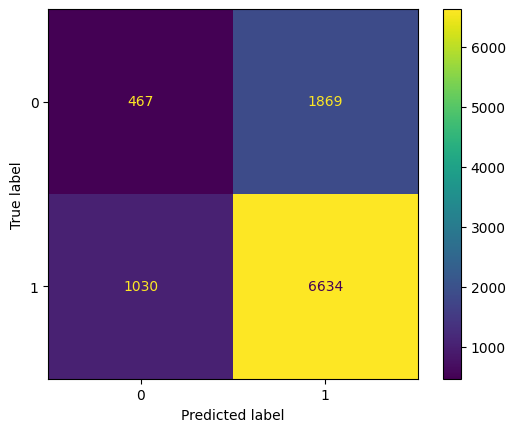

In [64]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(synth_y, model_voting.predict(synth_X))
).plot()

In [65]:
print(metrics.classification_report(synth_y, model_gb.predict(synth_X)))

              precision    recall  f1-score   support

       False       0.30      0.20      0.24      2336
        True       0.78      0.86      0.82      7664

    accuracy                           0.70     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.67      0.70      0.68     10000



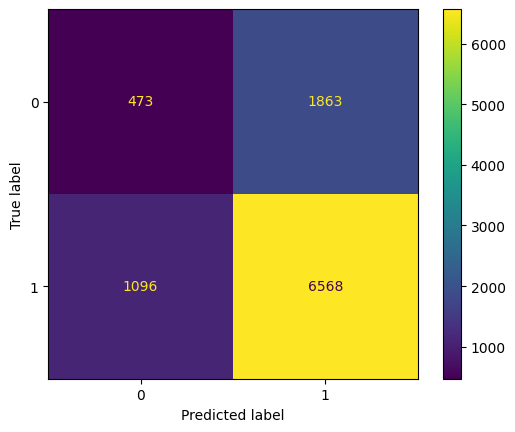

In [66]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(synth_y, model_gb.predict(synth_X))
).plot()

### Second Synthetic Data Attempt

In [90]:
ad_synth_2_user_ids = ad_synth_df_2["user_id"].unique()
ad_synth_2_user_ids

user_id
i64


In [87]:
synth_X = feed_synth_df_2.select([
    "label",
    "e_section",
    "e_rn",
    "i_upTimes",
    "i_dislikeTimes",
    "u_refreshTimes",
    "u_feedLifeCycle",
    "u_browserLifeCycle",
])
synth_y = feed_synth_df_2.select(pl.col("user_id").is_in(ad_synth_2_user_ids).alias("in_ads"))["in_ads"]

In [88]:
print(metrics.classification_report(synth_y, model_voting.predict(synth_X)))

              precision    recall  f1-score   support

       False       1.00      0.14      0.25    100000
        True       0.00      0.00      0.00         0

    accuracy                           0.14    100000
   macro avg       0.50      0.07      0.12    100000
weighted avg       1.00      0.14      0.25    100000



/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sygio/Documents/work/ucla-hack/modeling/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

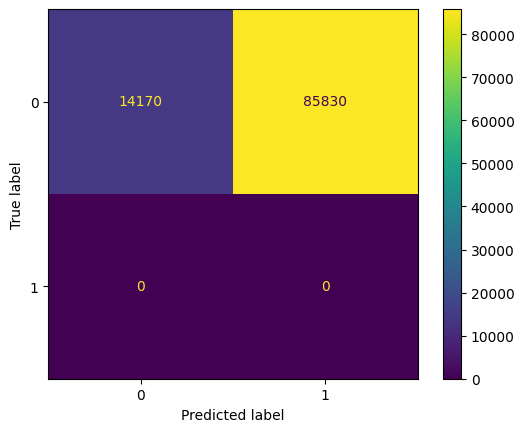

In [89]:
_ = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(synth_y, model_voting.predict(synth_X))
).plot()